In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from os.path import join, exists, basename, dirname

import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = join(gwfm_dir, 'Oneto_Denier')
dat_dir = join(proj_dir,'Stream_level_data')
map_dir = join(gwfm_dir,'Mapping')

sfr_dir = join(gwfm_dir,'SFR_data')
hob_dir = join(gwfm_dir,'HOB_data')

In [3]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [4]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 


In [5]:
def gdf_bnds(gdf, ax, buf=1):
    gdf_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [gdf.unary_union.buffer(buf)], crs=gdf.crs)
    minx, miny, maxx, maxy = gdf_bnd.bounds.values[0]
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    return(gdf_bnd)



In [6]:
rivers = gpd.read_file(join(sfr_dir,"Sac_valley_rivers/Sac_valley_rivers.shp"))
rivers = rivers.to_crs('EPSG:32610')

mb_regional = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
# mb = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
rivers_clip = gpd.clip(rivers, mb_regional)

soam = gpd.read_file(join(map_dir,"so_am_subbasin/so_am_subbasin.shp"))
soam = soam.to_crs('EPSG:32610')
cos = gpd.read_file(join(map_dir,"cos_subbasin/cos_subbasin.shp"))
cos = cos.to_crs('EPSG:32610')

ca = gpd.read_file(join(map_dir,"ca_state_boundary/CA_State_TIGER2016.shp"))
ca = ca.to_crs('EPSG:32610')

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [78]:
cr = rivers_clip[rivers_clip.GNIS_Name=='Cosumnes River']
mr = rivers_clip[rivers_clip.GNIS_Name=='Mokelumne River']

In [7]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'

In [8]:
grid_p['id'] = 0
m_domain = grid_p.dissolve('id')

In [9]:
df = pd.read_csv(join(hob_dir,'CosumnesRiverPreserve_MW_screened_interval.csv'))
rm_sp = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp = rm_sp.rename(columns={'Well ID':'Sensor'})

# prepare output for modelgrid join
rm_t = rm_sp[rm_sp['At Oneto-Denier']=='Yes']


In [10]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
# ifp = gpd.read_file(join(lak_shp,'inner_floodplain_domain/inner_floodplain_domain.shp' )).to_crs('epsg:32610')
# lfp = gpd.read_file(join(lak_shp,'lower_floodplain_approximate_area/lower_floodplain_approximate_area.shp' )).to_crs('epsg:32610')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')

fp_logger = pd.read_csv(join(gwfm_dir,'LAK_data','floodplain_logger_metadata.csv'))
fp_logger = gpd.GeoDataFrame(fp_logger, geometry = gpd.points_from_xy(fp_logger.Easting, fp_logger.Northing), crs='epsg:32610')
# find grid cell it is within
# fp_grid = gpd.sjoin(fp_logger, grid_p, how='left',op='within')

In [11]:
od_breach = fp_logger[fp_logger['Logger Location']=='OD_Excavation']
od_swale = fp_logger[fp_logger['Logger Location']=='SwaleBreach_1']

In [72]:


legend_elements = [
    Patch(facecolor='none', edgecolor='black',alpha=1., label='Model Extent'),
    Patch(facecolor='tab:blue', alpha=0.5, label='Reconnected Floodplain'),
    Line2D([0], [0],color='tab:blue',label='Cosumnes River'),
    Line2D([0], [0], marker='.', linestyle='', color='blue', label='Monitoring Well'),
]


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1ad1e22c130>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1ad1e22d9f0>)

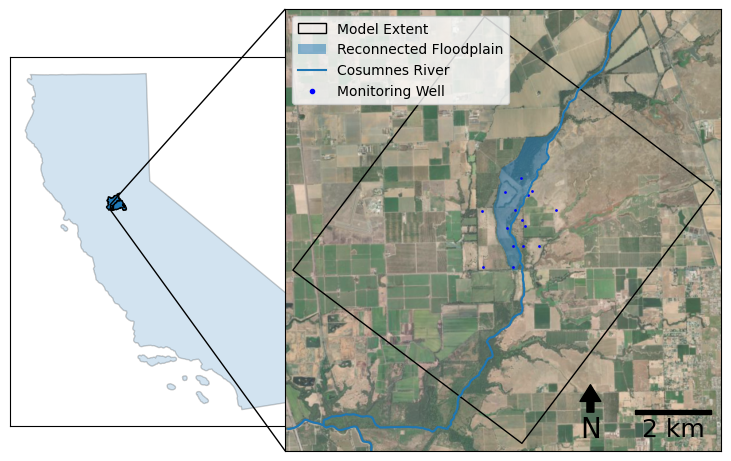

In [79]:
fig, axins =plt.subplots()

# second one is smaller inset
axins.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

ca.plot(ax = axins,alpha = 0.2, edgecolor='black')
soam.plot(ax = axins, edgecolor = 'black')
cos.plot(ax = axins, edgecolor = 'black')

# first one is CA map
ax = inset_axes(axins, width="100%", height="100%", bbox_to_anchor=(0.8, -.1, 1.3, 1.3),
                  bbox_transform=axins.transAxes, loc=2)
ax.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

plt_bnds = gdf_bnds(m_domain,ax=ax, buf=200)
# plt_bnds.plot(ax=axins, color='none')

# od_breach.plot(ax=ax)
# od_swale.plot(ax=ax)

m_domain.plot(color="none",edgecolor='black',ax=ax)

cr.plot(ax=ax, color='tab:blue')
mr.plot(ax=ax, color='tab:blue')

lak_extent.plot(ax=ax, color='tab:blue',  alpha=0.5)
rm_t.plot(legend=False,ax=ax, color='blue', markersize=1)

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.8)

x, y, arrow_length = 0.7, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, 
            xycoords=ax.transAxes)

fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           2000, '2 km', 'lower right', pad=0.3, sep=2,color='black',
                           frameon=False, size_vertical=1E2, fontproperties=fontprops)
ax.add_artist(scalebar)

ax.legend(handles=legend_elements, loc='upper left')

mark_inset(axins, ax, loc1=2, loc2=3, fc="none", ec="black")


# Model summary plots
It would be cool to have functions that are built on using the flopy output rather than using input data even slightly slower because then there is more interoperability

In [12]:
loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/'
model_nam = 'oneto_denier_2014_2018/'
model_ws = loadpth+model_nam
model_ws

'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/oneto_denier_2014_2018/'

In [13]:
m = flopy.modflow.Modflow.load(f = 'MF.nam',  model_ws = model_ws)

In [14]:
tmuni = ['s','m','h','D','M','Y'][m.dis.itmuni-1]
tr = ~m.dis.steady.array
delr = m.dis.delr[0]
delc = m.dis.delc[0]


In [15]:
strt_date = pd.to_datetime(m.dis.start_datetime)
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
hrs_from_strt = ((np.append([0], np.repeat(stplen, m.dis.nstp.array)[:-1])).cumsum()*24).astype('timedelta64[h]')
dates_stps = strt_date + hrs_from_strt

## Time series plots

In [16]:
sfr_tab = pd.read_csv(join(model_ws,m.name+'.tab'), delimiter = '\t', header=None, names=['time','flow'])
sfr_tab['dt'] = strt_date + sfr_tab.time.astype('timedelta64[D]')
sfr_tab = sfr_tab.set_index('dt')


In [17]:
gdes = m.evt.exdp.array[0, 0]==10


In [53]:
flux_sum = pd.DataFrame(columns=['spd','wel','rch','evt']).set_index('spd')
for n in np.arange(0, m.dis.nper):
    spd_n = m.wel.stress_period_data[n]
    if spd_n is not None:
        flux_sum.loc[n,'wel'] = spd_n.flux.sum()*-1
    spd_n = m.rch.rech[n]
    if spd_n is not None:
        flux_sum.loc[n,'rch'] = spd_n.sum() *(delr*delc)
    spd_n = m.evt.evtr[n]
    if spd_n is not None:
        flux_sum.loc[n,'evt'] = spd_n.array[gdes].sum() *(delr*delc)
# add dates columns
flux_sum['dt'] = dates_stps
flux_tr = flux_tr.reset_index().set_index('dt')

In [19]:
# join sfr to other flux data but only for transient periods
flux_tr = flux_sum[1:].join(sfr_tab[1:], on='dt')

In Randy Hanson 2010 paper on FMP applications. ET Groundwater is pink, ET irrig is blue, ET precip is orange. Recharge is green, runoff is brown

In [37]:
import matplotlib.ticker as ticker


C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0.5, 0.01, 'Date')

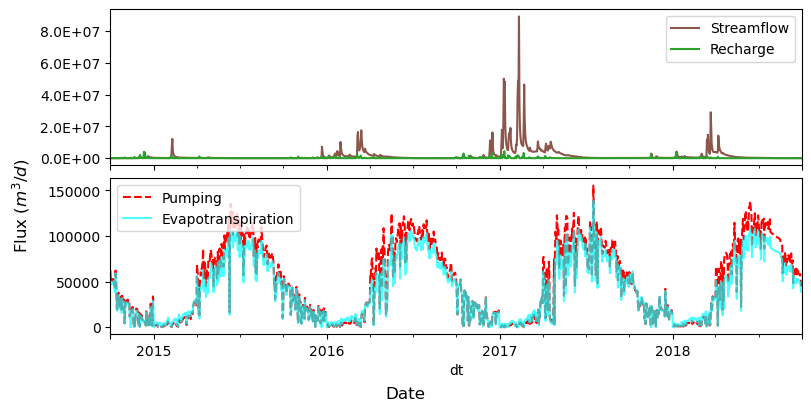

In [58]:

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,4), layout='constrained',)
# ax_r = ax[0].twinx()
flux_tr.plot(y=['flow'], ax=ax[0], label=['Streamflow'], color='tab:brown')
flux_tr.plot(y=['rch'], ax=ax[0], label=['Recharge'], color='tab:green')
# ax[0].set_yscale('log')
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1E}'.format(x)))

flux_tr.plot(y=['wel'], ax=ax[1], label=['Pumping'], color='red', linestyle='--') #tab:blue
flux_tr.plot(y=['evt'], ax=ax[1], label=['Evapotranspiration'], color= 'aqua', alpha=0.7) #tab:pink

fig.supylabel('Flux ($m^3/d$)')
fig.supxlabel('Date')

## Map spatial coverage of boundary conditions

In [21]:
uzf_dir = join(gwfm_dir, 'UZF_data')
gde_dir = join(uzf_dir,'shp_GDE_TFT')
GDE_cell = gpd.read_file(join(gde_dir,'GDE_cell.shp'))



In [22]:

wel_ss = pd.DataFrame(m.wel.stress_period_data[0])
ag_grid_p = grid_p.set_index(['row','column']).loc[list(zip(wel_ss.i+1, wel_ss.j+1))].reset_index()
GDE_grid_p = grid_p.join(GDE_cell.drop(columns='geometry').set_index(['node','row','column']), 
                         on=['node','row','column'], how='inner')
# save dataframe of stream reach data
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)


In [23]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
                   Patch(facecolor='aqua',alpha=0.8,
                         label='GDE Evapotranspiration'),
                   Patch(facecolor='red', edgecolor='r',alpha=0.6,
                         label='Agricultural Pumping'),
                       Patch(facecolor='none', edgecolor='tab:blue',alpha=1,
                         label='Reconnected Floodplain'),
                    Line2D([0], [0],color='tab:blue',label='Cosumnes River')]


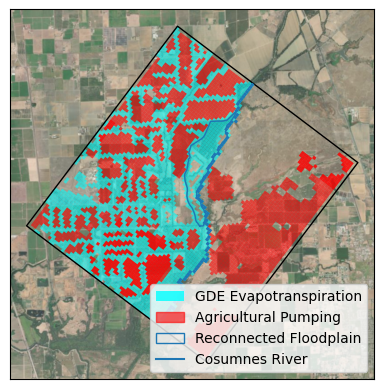

In [24]:
fig, ax = plt.subplots()
ag_grid_p.plot(ax=ax, color='red', alpha=0.6)
GDE_grid_p.plot(ax=ax, color='aqua', alpha=0.6)
m_domain.plot(ax=ax, color='none', edgecolor='black')

grid_sfr.plot(ax=ax, color='tab:blue')
lak_extent.plot(ax=ax,color='none',edgecolor='tab:blue')

ax.legend(handles=legend_elements, loc='lower right')

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.8)

# drop axis labels for cleaner plot
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)